# Transfer Learning

based on coursera

 - https://www.coursera.org/learn/convolutional-neural-networks-tensorflow/supplement/G6RPR/applying-transfer-learning-to-cats-v-dogs-lab-1


We will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as your base model

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras import layers
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory # 'tis a function
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files

## download dataset

In [2]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-01-10 05:12:19--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.7MB/s    in 4.0s    

2023-01-10 05:12:23 (16.5 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### download pretrained model h5 formatted

In [3]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-01-10 05:12:23--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  23.6MB/s    in 4.8s    

2023-01-10 05:12:28 (17.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [4]:
# Unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [5]:

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Using samplewise pixel standardization with augmentation



In [6]:
# create generator that standardize pixel values
train_datagen = ImageDataGenerator( samplewise_center=True, samplewise_std_normalization=True,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
# of course we don't augment the validation dataset because it supposedly reflect outside or real life data
test_datagen  = ImageDataGenerator( samplewise_center=True, samplewise_std_normalization=True )



In [7]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Model

create 'empty unweighted' model that based on architecture on h5 file then load its weight into the model. After that we freeze the model from training by set `layers.trainable` to `False`

In [8]:
# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [9]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [10]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


### Add dense layers and dropout

In [11]:
last_output


<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

In [12]:
# Flatten the output layer to 1 dimension
x = layers.Flatten(name='flatten_the_last_output')(last_output)
x

<KerasTensor: shape=(None, 37632) dtype=float32 (created by layer 'flatten_the_last_output')>

Add dense layer with dropout and sigmoid as final output

In [13]:
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu', name='our_1st_dense_layer')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2, name='our_1st_dropout_layer')(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid',  name='our_2nd_dense_layer_for_binary_output')(x)  

Add into new model

In [14]:
# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 


In [15]:
# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [16]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

### Training the model

we only need to train the dense layer after layer7 from inception model

#### batch size for training calc

In [17]:
# Constant for epochs
EPOCHS = 20

train_steps_per_epoch = len(train_generator.labels)/train_generator.batch_size
validation_steps_per_epoch = len(validation_generator.labels)/validation_generator.batch_size

print('train_steps_per_epoch:', train_steps_per_epoch )

print('validation_steps_per_epoch:', validation_steps_per_epoch )
     

train_steps_per_epoch: 100.0
validation_steps_per_epoch: 50.0


In [18]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = train_steps_per_epoch,
            epochs = 20,
            validation_steps = validation_steps_per_epoch,
            verbose = 2)

Epoch 1/20
100/100 - 31s - loss: 0.5379 - accuracy: 0.7600 - val_loss: 0.3669 - val_accuracy: 0.8510 - 31s/epoch - 312ms/step
Epoch 2/20
100/100 - 19s - loss: 0.3936 - accuracy: 0.8210 - val_loss: 0.2877 - val_accuracy: 0.8790 - 19s/epoch - 186ms/step
Epoch 3/20
100/100 - 21s - loss: 0.3730 - accuracy: 0.8330 - val_loss: 0.3532 - val_accuracy: 0.8710 - 21s/epoch - 212ms/step
Epoch 4/20
100/100 - 19s - loss: 0.3401 - accuracy: 0.8490 - val_loss: 0.3715 - val_accuracy: 0.8630 - 19s/epoch - 191ms/step
Epoch 5/20
100/100 - 19s - loss: 0.3400 - accuracy: 0.8610 - val_loss: 0.2226 - val_accuracy: 0.9170 - 19s/epoch - 186ms/step
Epoch 6/20
100/100 - 19s - loss: 0.3215 - accuracy: 0.8635 - val_loss: 0.2434 - val_accuracy: 0.9130 - 19s/epoch - 191ms/step
Epoch 7/20
100/100 - 19s - loss: 0.3374 - accuracy: 0.8580 - val_loss: 0.2165 - val_accuracy: 0.9150 - 19s/epoch - 185ms/step
Epoch 8/20
100/100 - 19s - loss: 0.2921 - accuracy: 0.8760 - val_loss: 0.2406 - val_accuracy: 0.9260 - 19s/epoch - 185

## Evaluate the results

The validation accuracy is also trending upwards as your training accuracy improves. This is a good sign that the model is no longer overfitting!

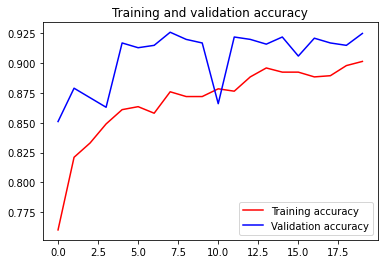

<Figure size 432x288 with 0 Axes>

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

#### test the model

image were taken from pixabay

In [23]:
labels = (train_generator.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
labels

{'cats': 0, 'dogs': 1}


{0: 'cats', 1: 'dogs'}

Saving kitty-2948404_1280.jpg to kitty-2948404_1280.jpg
Saving leopard-515509_1280.jpg to leopard-515509_1280.jpg
Saving dog-3277417_1280.jpg to dog-3277417_1280 (3).jpg
Saving labrador-retriever-1210559_1280.jpg to labrador-retriever-1210559_1280 (3).jpg
Saving bulldog-1047518_1280.jpg to bulldog-1047518_1280 (3).jpg
Saving tiger-1868911_1280.jpg to tiger-1868911_1280 (7).jpg
Saving cat-2083492_1280.jpg to cat-2083492_1280 (5).jpg
(1, 150, 150, 3)
1/1 [==============================] - 0s 25ms/step
[[0.54922384]]
1
kitty-2948404_1280.jpg is a : dogs


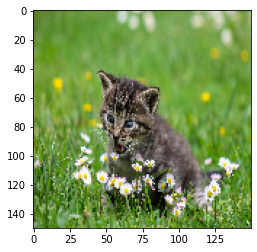

(1, 150, 150, 3)
1/1 [==============================] - 0s 25ms/step
[[0.13856697]]
0
leopard-515509_1280.jpg is a : cats


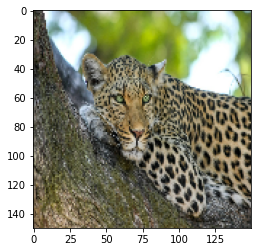

(1, 150, 150, 3)
1/1 [==============================] - 0s 24ms/step
[[1.]]
1
dog-3277417_1280.jpg is a : dogs


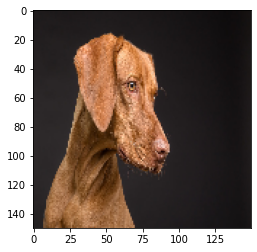

(1, 150, 150, 3)
1/1 [==============================] - 0s 24ms/step
[[1.]]
1
labrador-retriever-1210559_1280.jpg is a : dogs


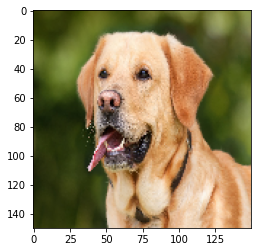

(1, 150, 150, 3)
1/1 [==============================] - 0s 23ms/step
[[0.01434637]]
0
bulldog-1047518_1280.jpg is a : cats


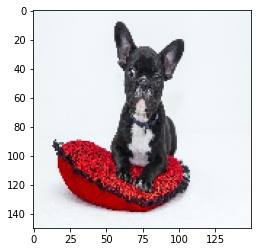

(1, 150, 150, 3)
1/1 [==============================] - 0s 21ms/step
[[0.9890856]]
1
tiger-1868911_1280.jpg is a : dogs


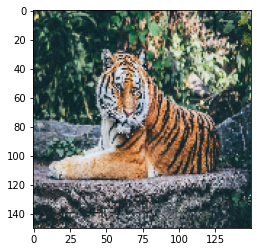

(1, 150, 150, 3)
1/1 [==============================] - 0s 24ms/step
[[0.9883775]]
1
cat-2083492_1280.jpg is a : dogs


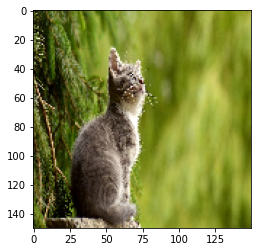

In [38]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
from matplotlib.pyplot import imshow, show 

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  print(x.shape)
  for x_i in train_datagen.flow(x, batch_size = 1):
    images = np.vstack([x_i])
    classes = model.predict(images, batch_size=10)
    print(classes)
    predicted_class_indices = int(np.round_(classes[0][0]))
    print(predicted_class_indices)
    predictions = labels[predicted_class_indices]
    print(fn, 'is a :', predictions)
    plt.imshow(img)
    show()
    break

seems like greenery background would fool the model in predicting cats as dogs

Saving cats-eyes-2671903_1280.jpg to cats-eyes-2671903_1280.jpg
Saving cat-98359_1280.jpg to cat-98359_1280 (1).jpg
(1, 150, 150, 3)
1/1 [==============================] - 0s 22ms/step
[[0.00416267]]
0
cats-eyes-2671903_1280.jpg is a : cats


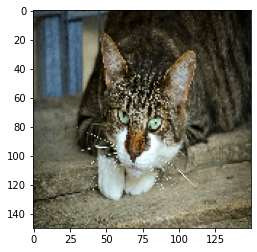

(1, 150, 150, 3)
1/1 [==============================] - 0s 22ms/step
[[0.00029899]]
0
cat-98359_1280.jpg is a : cats


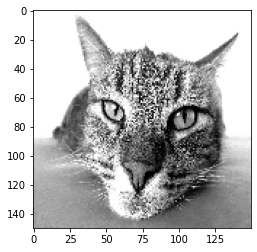

In [41]:


uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  print(x.shape)
  for x_i in train_datagen.flow(x, batch_size = 1):
    images = np.vstack([x_i])
    classes = model.predict(images, batch_size=10)
    print(classes)
    predicted_class_indices = int(np.round_(classes[0][0]))
    print(predicted_class_indices)
    predictions = labels[predicted_class_indices]
    print(fn, 'is a :', predictions)
    plt.imshow(img)
    show()
    break

Saving maltese-1123016_1280.jpg to maltese-1123016_1280.jpg
Saving husky-3380548_1280.jpg to husky-3380548_1280.jpg
Saving corgi-4415649_1280.jpg to corgi-4415649_1280.jpg
(1, 150, 150, 3)
1/1 [==============================] - 0s 24ms/step
[[0.5059162]]
1
maltese-1123016_1280.jpg is a : dogs


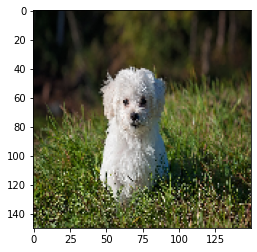

(1, 150, 150, 3)
1/1 [==============================] - 0s 25ms/step
[[0.14842859]]
0
husky-3380548_1280.jpg is a : cats


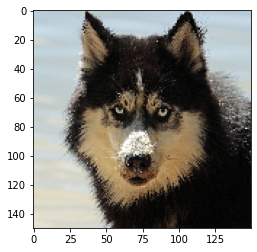

(1, 150, 150, 3)
1/1 [==============================] - 0s 24ms/step
[[0.06436457]]
0
corgi-4415649_1280.jpg is a : cats


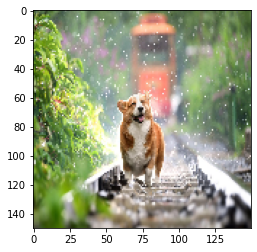

In [42]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
from matplotlib.pyplot import imshow, show 

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
  print(x.shape)
  for x_i in train_datagen.flow(x, batch_size = 1):
    images = np.vstack([x_i])
    classes = model.predict(images, batch_size=10)
    print(classes)
    predicted_class_indices = int(np.round_(classes[0][0]))
    print(predicted_class_indices)
    predictions = labels[predicted_class_indices]
    print(fn, 'is a :', predictions)
    plt.imshow(img)
    show()
    break

And dogs with pointy ears would fool the model in predicting dogs as cats